In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import sys
sys.path.insert(1, '../src')

from model import DeepONet
from wave_loader import *

path = '../'

In [2]:
paths = glob('../data/10/*.npy')
ds_train, ds_valid = get_wave_datasets(paths)

In [3]:
# Convergence test
model = DeepONet(10, 128, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=1-1e-3)
epochs = 1000
batch_size = 10
loss_function = torch.nn.MSELoss()

epoch_train_losses = []
epoch_validation_losses = []

train_dataloader = DataLoader(ds_train, batch_size=10, shuffle=True)
validation_dataloader = DataLoader(ds_valid, batch_size=10, shuffle=True)

In [4]:
for epoch in range(epochs):
    train_losses = []

    for (xt_batch, y_batch, u_batch) in train_dataloader:
        optimizer.zero_grad()
        # Forward pass through network
        pred = model(u_batch, xt_batch)
        loss = loss_function(pred, y_batch.view(-1))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))
    lr_scheduler.step()

    if epoch % 10 == 0:
        # Do validation
        validation_losses = []
        model.eval()
        for (xt_batch, y_batch, u_batch) in validation_dataloader:
            pred = model(u_batch, xt_batch)
            loss = loss_function(pred, y_batch.view(-1))
            validation_losses.append(loss.item())

        epoch_validation_losses.append(np.mean(validation_losses))
        model.train()
        # Print train and validation loss
        print(f'Epoch {epoch:05d}\tTrain loss: {epoch_train_losses[-1]:.6f}\tValidation loss: {epoch_validation_losses[-1]:.6f}')   
        

Epoch 00000	Train loss: 19.516083	Validation loss: 17.191422
Epoch 00010	Train loss: 1.246370	Validation loss: 49.646033
Epoch 00020	Train loss: 0.818860	Validation loss: 42.373581
Epoch 00030	Train loss: 0.491575	Validation loss: 37.873502
Epoch 00040	Train loss: 0.710205	Validation loss: 32.570155
Epoch 00050	Train loss: 0.363841	Validation loss: 36.905678
Epoch 00060	Train loss: 0.655401	Validation loss: 37.538746
Epoch 00070	Train loss: 0.499480	Validation loss: 34.676404
Epoch 00080	Train loss: 0.415220	Validation loss: 36.764514
Epoch 00090	Train loss: 0.195650	Validation loss: 34.018152
Epoch 00100	Train loss: 0.360538	Validation loss: 35.472330
Epoch 00110	Train loss: 0.382950	Validation loss: 36.305627
Epoch 00120	Train loss: 0.256317	Validation loss: 37.043564
Epoch 00130	Train loss: 0.387290	Validation loss: 38.823351
Epoch 00140	Train loss: 0.866730	Validation loss: 38.412041
Epoch 00150	Train loss: 0.100912	Validation loss: 40.777405
Epoch 00160	Train loss: 0.430387	Valida

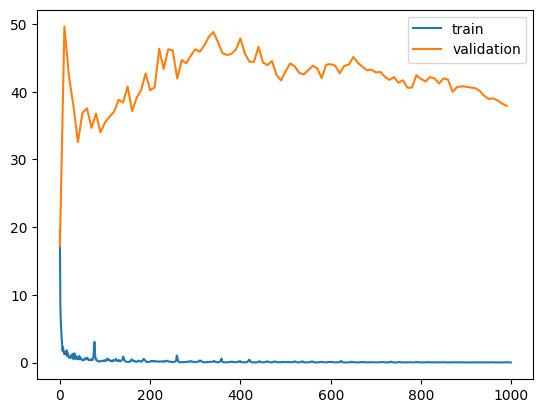

In [5]:
# Plot train and validation loss
plt.plot(np.arange(0, epochs, 1), epoch_train_losses, label='train')
plt.plot(np.arange(0, epochs, 10), epoch_validation_losses, label='validation')
plt.legend()
plt.show()

Try and predict trajectories of an initial condition included in the training set.

In [6]:
xts = ds_train[:][0]
ys = ds_train[:][1]
us = ds_train[:][2]

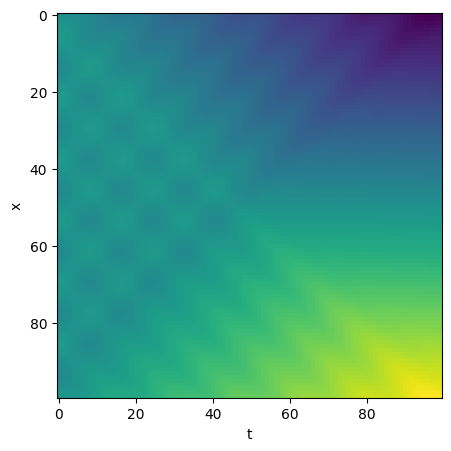

In [7]:
test = np.load('../data/10/0.npy', allow_pickle=True)
xs = test[0][0]
ts = test[0][1]
ys = test[0][2]
us = test[0][3]

fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.imshow(ys)

plt.show()


In [8]:
XT = np.meshgrid(xs, ts)
trunk_input = torch.from_numpy(np.vstack([XT[0].ravel(), XT[1].ravel()]).T).float()
branch_input = torch.from_numpy(us).float()

In [9]:
model.set_batch(False)
deep_output = np.zeros_like(ys)
for i, xt in enumerate(trunk_input):
    j = i // 100
    deep_output[i % 100, j] = model(branch_input, xt)

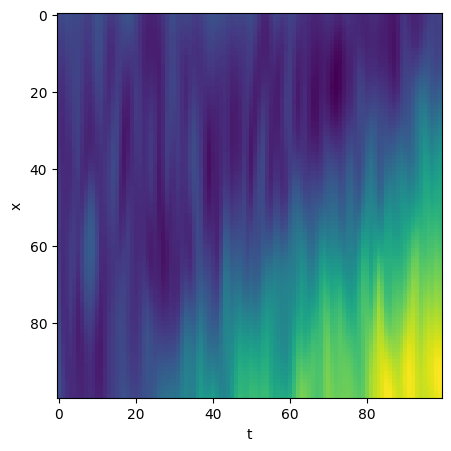

In [10]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.imshow(deep_output)

plt.show()

# Conclusion
We are unable to predict trajectories with the training data of 10 sensors and a limited amount of data, but the model passes convergence test as training error is reducing. 